In [1]:
import sys
sys.path.append("/home/chrhck/repos/jammy_flows/")
import jammy_flows
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset,ConcatDataset
from torch.optim import Adam 
import math
import pandas as pd
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
import jammy_flows.helper_fns as helper_fns
import corner

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
def make_hook(fn):
    def hook(i, o):
        print(fn, i, o)
    fn.register_hook(hook)


a = torch.tensor([2.], requires_grad=True)
b = torch.tensor([3.], requires_grad=True)

c = a**2 * torch.exp(b)
make_hook(c.grad_fn.next_functions[0][0])
make_hook(c.grad_fn.next_functions[1][0])
make_hook(c.grad_fn)

c.backward()

print(a.grad)
print(b.grad)







<MulBackward0 object at 0x7f1c62d07400> (tensor([20.0855]), tensor([4.])) (tensor([1.]),)
<ExpBackward0 object at 0x7f1c62d073d0> (tensor([80.3421]),) (tensor([4.]),)
<PowBackward0 object at 0x7f1c62d07430> (tensor([80.3421]),) (tensor([20.0855]),)
tensor([80.3421])
tensor([80.3421])


In [3]:
def cart_to_sph(x, y, z):
    out = np.empty((x.shape[0], 2))

    out[:, 0] = np.arccos(z)

    atan = np.arctan2(y, x)

    mask = (x != 0) & (y != 0)
    out[mask, 1] = atan[mask]

    mask = (x==0) & (y!=0)
    out[mask, 1] = np.pi/2 * np.sign(y[mask])

    mask = (x==0) & (y==0)
    out[mask, 1] = 0

    mask = out[:, 1] < 0
    out[mask, 1] = out[mask, 1] + 2*np.pi

    return out

def sph_to_cart(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z

def seed_everything(seed_no):
    random.seed(seed_no)
    np.random.seed(seed_no)
    torch.manual_seed(seed_no)




In [4]:
class HDF5PMTTable(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PMTTable).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.weights = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]

            data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
            data_df = data_df.loc[data_df["weight"] > 0]


            if len(data_df) > 1000:
                data_df = data_df.sample(1000)


            data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())
            data = data_df.to_numpy()

            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[:, 1] - 1), 16)

            labels = torch.empty((data.shape[0], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]

            #time_res = torch.DoubleTensor(data[:, 0]) - labels[:, 0] / (0.25)
            labels[:, len(label_order):] = pmt_encoding
            
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            self.data.append(torch.DoubleTensor(data[:, 0]))
            self.weights.append(torch.DoubleTensor(data[:, 2]))
            self.labels.append(labels)
        
        self.data = torch.concat(self.data)
        self.weights = torch.concat(self.weights)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.weights[key], self.labels[key]


class HDF5PMTTableUnWeighted(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PMTTableUnWeighted).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]

            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[0] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]

            #time_res = torch.DoubleTensor(data[:, 0]) - labels[:, 0] / (0.25)
            labels[:, len(label_order):] = pmt_encoding
            
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            self.data.append(torch.DoubleTensor(data[0]))
            self.labels.append(labels)
        
        self.data = torch.concat(self.data)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.labels[key]

    """
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        for i in range(iter_start, iter_end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]
            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[1] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]
            
            labels[:, len(label_order):] = pmt_encoding

            yield torch.DoubleTensor(data[0]).to(device), torch.DoubleTensor(data[2]).to(device), labels.to(device)
    """


class TimeTransform(object):
    def __init__(self, offset):
        self.offset = offset

    def __call__(self, x):
        return np.log10(x + self.offset)

    def inv(self, x):
        return np.power(10, x) - self.offset

class MinMaxScaler(object):
    def __init__(self, min, max, fmin, fmax):
        self.min = min
        self.max = max
        
        self.a = (fmax - fmin) / (max + 1)
        self.b = fmin - self.a * min

    def __call__(self, x):
        return self.a*x + self.b

    def inv(self, x):
        return (x - self.b) / self.a


class HDF5PPhotonTable(Dataset):
    def __init__(self, files, time_range=(-50, np.inf)):
        super(HDF5PPhotonTable).__init__()
        
        label_order = ["distance", "energy", "dir_costheta", "dir_phi"]
       
        self.data = []
        self.labels = []

        self.data_transforms = [None, None, None, None]
        self.label_transforms = []
           
        if time_range[0] > -np.inf:
            self.data_transforms[0] = TimeTransform(-time_range[0])
        
        for fn in files:
            with h5py.File(fn) as hdl:       
                ds_groups = sorted(hdl["photons"].keys())
                for i in range(len(ds_groups)):
                    grp = ds_groups[i]
                    
                    data = hdl["photons"][grp][:]

                    
                    wsum = np.sum(data[4])

                    if wsum == 0:
                        continue

                    ixs = np.arange(data.shape[1])
                    np.random.choice(ixs, p=data[4]/wsum, replace=False, size=int(np.floor(wsum)))
                    data = data[:, ixs]

                    
                    labels_d = dict(hdl["photons"][grp].attrs)

                    cart_dir = sph_to_cart(np.arccos(labels_d["dir_costheta"]), labels_d["dir_phi"])
                    labels = torch.empty((data.shape[1], 5), dtype=torch.float64)
                    labels[:, 0] = np.log10(np.float64(labels_d["distance"]))
                    labels[:, 1] = np.log10(np.float64(labels_d["energy"]))
                    labels[:, 2] = cart_dir[0]
                    labels[:, 3] = cart_dir[1]
                    labels[:, 4] = cart_dir[2]

                    time_mask = (data[0] > time_range[0]) & (data[0] < time_range[1])

                    data = data[:,time_mask]
                    data = data[:, :1000]
                    

                    data_t = torch.empty((data.shape[1], 4), dtype=torch.float64)
                    data_t[:, 0] = torch.DoubleTensor(data[0])
                
                    xyz = data[1:4] / np.linalg.norm(data[1:4], axis=0)

                    sph = torch.DoubleTensor(cart_to_sph(xyz[0], xyz[1], xyz[2]))
                    data_t[:, 1:3] = sph
                    data_t[:, 3] = torch.DoubleTensor(data[-1] / (np.sum(data[-1]) * data.shape[0]))

                    self.data.append(data_t)
                    self.labels.append(labels)
        
        self.data = torch.vstack(self.data)

        for i in range(self.data.shape[1]):
            if self.data_transforms[i] is not None:
                self.data[:, i] = self.data_transforms[i](self.data[:, i])

        self.labels = torch.concat(self.labels)

        for i in range(self.labels.shape[1]):
            tf = MinMaxScaler(torch.min(self.labels[:, i]).numpy(), torch.max(self.labels[:, i]).numpy(), -1, 1)
            self.labels[:, i] = tf(self.labels[:, i])
            self.label_transforms.append(tf)


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.labels[key]


In [5]:
def read_pmt_table_hdf(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photon_tables"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
        data_df = data_df.loc[data_df["weight"] > 0]

        data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())

        
        labels_d = dict(hdl["photon_tables"][grp].attrs)
        
    return data_df, labels_d

def read_pmt_table_hdf_unweighted(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photon_tables"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["pmt_id", "tres"])
        labels_d = dict(hdl["photon_tables"][grp].attrs)
        
    return data_df, labels_d

def read_photon_table_hdf_unweighted(fname, ix, ds):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photons"].keys())

        label_order = ["distance", "energy", "dir_costheta", "dir_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photons"][grp][:]
        wsum = np.sum(data[4])

        ixs = np.arange(data.shape[1])
        np.random.choice(ixs, p=data[4]/wsum, replace=False, size=int(np.floor(wsum)))
        data = data[:, ixs]


        data_df = pd.DataFrame(data.T, columns=["tres", "pos_x", "pos_y", "pos_z", "weight"])
        
        if ds.data_transforms[0] is not None:
            data_df["tres_tf"] = ds.data_transforms[0](data_df["tres"])

        labels_d = dict(hdl["photons"][grp].attrs)
        cart_dir = sph_to_cart(np.arccos(labels_d["dir_costheta"]), labels_d["dir_phi"])
        labels = torch.empty((data.shape[1], 5), dtype=torch.float64)
        labels[:, 0] = np.log10(np.float64(labels_d["distance"]))
        labels[:, 1] = np.log10(np.float64(labels_d["energy"]))
        labels[:, 2] = cart_dir[0]
        labels[:, 3] = cart_dir[1]
        labels[:, 4] = cart_dir[2]

        for i in range(labels.shape[1]):
            labels[:, i] = ds.label_transforms[i](labels[:, i])

        
        
    return data_df, labels


        

In [84]:
import distrax
import jax.numpy as jnp
import haiku as hk
import optax
import jax


def make_conditioner(hidden_sizes, out_params_activ, init_zero=True):
    """
    Build a conditioner MLP.
    Parameters:
        hidden_sizes: List
            List of layer sizes
        out_params_traf: List
            List of activations applied to final layer.
            Can be None, in which case no transformation is applied.
    """

    def final_activation(x):
        for i, op_t in enumerate(out_params_activ):
            if op_t is not None:
                x = x.at[:, i].set(op_t(x[:, i]))
        return x

    n_out_params = len(out_params_activ)

    if init_zero:
        final_linear = hk.Linear(n_out_params, w_init=jnp.zeros, b_init=jnp.zeros)
    else:
        final_linear = hk.Linear(n_out_params)

    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=1),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            final_linear,
            final_activation,
        ]
    )


def make_shape_conditioner_fn(
    mlp_hidden_size, mlp_num_layers, flow_num_bins, flow_num_layers
):

    num_bijector_params = 3 * flow_num_bins + 1
    num_bij_params = num_bijector_params * flow_num_layers

    @hk.without_apply_rng
    @hk.transform
    def shape_conditioner_fn(x):
        return make_conditioner(
            [mlp_hidden_size] * mlp_num_layers, [None] * num_bij_params
        )(x)

    return shape_conditioner_fn


def make_spl_flow(spl_params, rmin, rmax):
    """
    Make multiple spline flows.
    Paramaters:
        spl_params: List
            List of spline parameters per layer
        rmin, rmax: float
            Min and max range for spline
    """
    layers = []
    for spl_p in spl_params:
        layers.append(
            distrax.RationalQuadraticSpline(
                spl_p,
                range_min=rmin,
                range_max=rmax,
            )
        )
    return layers


def traf_dist_builder(flow_num_layers, flow_range, return_base=False):
    def make_transformed_dist(traf_params):
        spl_params = jnp.split(traf_params, flow_num_layers, axis=-1)

        base_dist = distrax.Gamma(1.5, 1 / 10)
        flow = make_spl_flow(spl_params, flow_range[0], flow_range[1]) + [
            distrax.ScalarAffine(shift=4, scale=1)
        ]
        flow = distrax.Inverse(distrax.Chain(flow))
        # flow = distrax.Chain(flow)
        transformed = distrax.Transformed(base_dist, flow)

        if return_base:
            return base_dist, flow

        return transformed

    return make_transformed_dist


def eval_log_prob(dist_builder, traf_params, samples):
    dist = dist_builder(traf_params)
    return dist.log_prob(samples)


def sample_shape_model(dist_builder, traf_params, n_photons, seed):
    base_dist, trafo = dist_builder(traf_params)
    base_samples = base_dist.sample(seed=seed, sample_shape=n_photons)
    return trafo.forward(base_samples)


def train_shape_model(config, train_loader, test_loader, seed=1337, writer=None):

    dist_builder = traf_dist_builder(
        config["flow_num_layers"],
        (config["flow_rmin"], config["flow_rmax"]),
    )

    shape_conditioner = make_shape_conditioner_fn(
        config["mlp_hidden_size"],
        config["mlp_num_layers"],
        config["flow_num_bins"],
        config["flow_num_layers"],
    )

    @jax.jit
    def ema_update(params, avg_params):
        return optax.incremental_update(params, avg_params, step_size=0.001)

    @jax.jit
    def loss_fn(params, cond, samples):

        traf_params = shape_conditioner.apply(params, cond)

        lprobs = eval_log_prob(dist_builder, traf_params, samples)
        finite = jnp.isfinite(lprobs)
        loss = -jnp.mean(lprobs * finite)
        return loss

    @jax.jit
    def update(params, opt_state, cond, samples):
        """Single SGD update step."""
        lval, grads = jax.value_and_grad(loss_fn)(params, cond, samples)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, lval

    scheduler = optax.cosine_decay_schedule(config["lr"], config["steps"], alpha=0.0)

    # scheduler = lambda _ : config["lr"]
    optimizer = optax.adam(learning_rate=scheduler)

    prng_seq = hk.PRNGSequence(seed)

    params = avg_params = shape_conditioner.init(next(prng_seq), jnp.ones((1, 2)))
    opt_state = optimizer.init(params)

    log_every = 100

    train_iter = iter(train_loader)
    for i in range(1, config["steps"] + 1):

        train = next(train_iter)
        cond = jnp.concatenate(train[:2]).T
        samples = jnp.squeeze(train[2])

        params, opt_state, train_loss = update(params, opt_state, cond, samples)
        avg_params = ema_update(params, avg_params)

        if (i % log_every) == 0:

            test_loss = 0
            for test in test_loader:
                cond = jnp.concatenate(test[:2]).T
                samples = jnp.squeeze(test[2])
                val_loss = loss_fn(avg_params, cond, samples)
                test_loss += val_loss
            test_loss /= test_loader._n_batches

            train_loss, test_loss = jax.device_get(
                (
                    train_loss,
                    test_loss,
                )
            )

            if writer is not None:
                writer.add_scalar("Loss/train", train_loss, i)
                writer.add_scalar("Loss/test", test_loss, i)
                # writer.add_scalar("LR", lr, epoch)
                writer.flush()
            print(f"Epoch: {i} \t Train/Test: {train_loss:.3E} / {test_loss:.3E}")
    return params


def make_counts_net_fn(config):
    @hk.without_apply_rng
    @hk.transform
    def net_fn(x):
        net = make_conditioner(
            [config["mlp_hidden_size"]] * config["mlp_num_layers"],
            [None],
            init_zero=False,
        )
        return net(x)

    return net_fn


def train_counts_model(config, train_loader, test_loader, seed=1337, writer=None):

    net_fn = make_counts_net_fn(config)

    @jax.jit
    def loss_fn(params, batch):
        inp = jnp.concatenate(batch[:2]).T
        out = net_fn.apply(params, inp).squeeze()
        return 0.5 * jnp.average((out - batch[2]) ** 2)

    @jax.jit
    def update(params, opt_state, batch):
        """Single SGD update step."""
        lval, grads = jax.value_and_grad(loss_fn)(params, batch)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, lval

    scheduler = optax.cosine_decay_schedule(config["lr"], config["steps"], alpha=0.0)

    optimizer = optax.adam(learning_rate=scheduler)

    prng_seq = hk.PRNGSequence(42)

    params = net_fn.init(next(prng_seq), jnp.ones((1, 2)))
    opt_state = optimizer.init(params)

    log_every = 100

    train_iter = iter(train_loader)
    for i in range(1, config["steps"] + 1):

        train = next(train_iter)

        params, opt_state, train_loss = update(params, opt_state, train)

        if (i % log_every) == 0:

            test_loss = 0
            for test in test_loader:
                val_loss = loss_fn(params, test)
                test_loss += val_loss
            test_loss /= test_loader._n_batches

            train_loss, test_loss = jax.device_get(
                (
                    train_loss,
                    test_loss,
                )
            )

            if writer is not None:
                writer.add_scalar("Loss/train", train_loss, i)
                writer.add_scalar("Loss/test", test_loss, i)
                # writer.add_scalar("LR", lr, epoch)
                writer.flush()
            print(f"Epoch: {i} \t Train/Test: {train_loss:.3E} / {test_loss:.3E}")

    if writer is not None:
        test_loss = 0
        test_loss = 0
        for test in test_loader:
            val_loss = loss_fn(params, test)
            test_loss += val_loss
        test_loss /= test_loader._n_batches
        test_loss = jax.device_get(test_loss)

        hparam_dict = dict(config)
        writer.add_hparams(hparam_dict, {"hparam/test_loss": test_loss})
        writer.flush()
        writer.close()
    return params

In [85]:
files = [
    "../assets/photon_tables_extended_1.hd5",
    "../assets/photon_table_extended_2.hd5"]

ds = HDF5PPhotonTable(files)
data_df, labels_plot = read_photon_table_hdf_unweighted("../assets/photon_tables_extended_1.hd5", 120, ds)

<AxesSubplot:xlabel='tres_tf', ylabel='Count'>

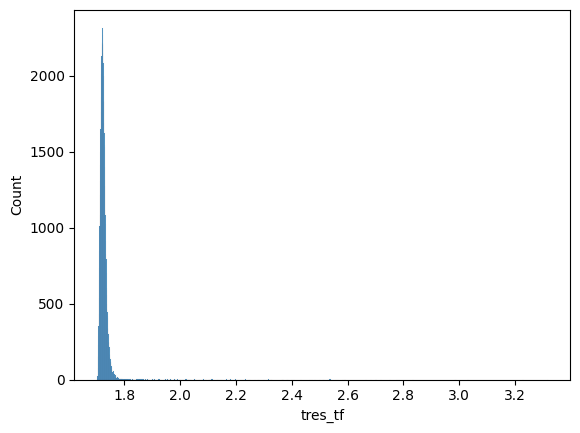

In [11]:
writer = SummaryWriter("/tmp/tensorboard/nflow_distrax")

In [73]:
import normflows as nf
masked = data_df.loc[data_df["tres"] < 150, :]
scaler = MinMaxScaler(min(masked["tres"]), 150, 0, 1)


ds = TensorDataset(torch.DoubleTensor(scaler(masked["tres"]))[:, np.newaxis])
split_len = int(np.ceil(0.9*len(ds)))
train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=5000)




epoch = 0
optim = Adam(pdf.parameters(), lr=0.001)
n_epochs = 100
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, n_epochs)

In [83]:
max(scaler(masked["tres"]))

0.9863480321618895

In [74]:
writer = SummaryWriter("/tmp/tensorboard/nflow_e1")

train_iter = 0
for epoch in range(epoch, 100):
    loss = 0
    pdf = pdf.to(device)
    for data in train_loader:
        train_iter += 1
        optim.zero_grad()

        data = data[0].to(device)
      
        log_pdf, _, _ = pdf(data) 
        neg_log_loss = (-log_pdf).mean()
        neg_log_loss.backward()

        optim.step()
        loss += neg_log_loss.detach()
       
    loss /= len(train_loader)
 
    loss_test = 0
    for data in test_loader:
        data = data[0].to(device)
       
        log_pdf, _, _ = pdf(data) 
        loss_test += (-log_pdf).mean().detach()
    
    loss_test /= len(test_loader)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', loss_test, epoch)
  
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")
    #sched.step()



AssertionError: 

(1e-05, 10000.0)

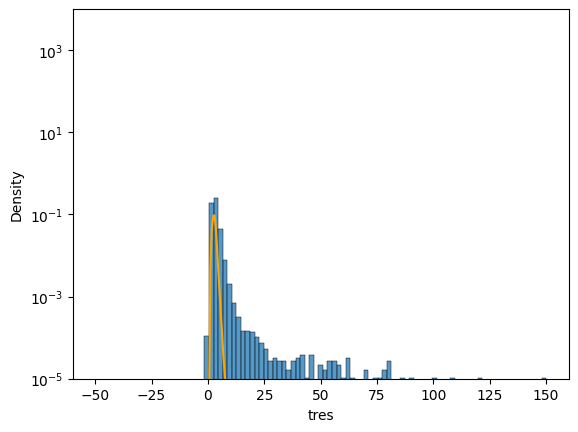

In [67]:
xs = torch.linspace(0, 50, 1000, dtype=torch.double)
sns.histplot(data=data_df, x="tres", stat="density", bins=np.linspace(-50, 150, 100))
plt.plot(xs, 10**pdf(xs[:, np.newaxis])[0].detach(), color="orange")
plt.semilogy()
plt.ylim(1E-5, 1E4)


In [47]:
seed_everything(31337)

files = [
    "../assets/photon_tables_extended_1.hd5",
    "../assets/photon_table_extended_2.hd5"]

ds = HDF5PPhotonTable(files)
split_len = int(np.ceil(0.9*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=5000)
extra_flow_defs = {
    "v": {
        "exp_map_type": "splines",
        #"nonlinear_stretch_type": "rq_splines"
    }
}
pdf = jammy_flows.pdf("e1+s2", "gg+n", conditional_input_dim=5, hidden_mlp_dims_sub_pdfs="256", options_overwrite=extra_flow_defs)
pdf.init_params(data=next(iter(train_loader))[0][:, :3])
epoch = 0
optim = Adam(pdf.parameters(), lr=0.001)
n_epochs = 100
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, n_epochs)



In [12]:
#model = torch.load("../assets/models/checkpoint_77.pt.pt")
#pdf.load_state_dict(model["model_state_dict"])
#optim.load_state_dict(model["optimizer_state_dict"])
#epoch = model["epoch"]


In [48]:
def make_plot(pdf, data_df, labels, traf):
    

    sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
    data_df["pos_theta"] = sph[:, 0]
    data_df["pos_phi"] = sph[:, 1]
    data_df["pos_costheta"] = np.cos(sph[:, 0])

    targ, bas, lpdf_targ, lpdf_bas = pdf.to("cpu").sample(samplesize=2000, conditional_input=labels[0, :].repeat(2000, 1))
    targ = pd.DataFrame(targ.numpy(), columns=["tres_tf", "pos_theta", "pos_phi"])

    data_df["group"] = "MC"
    targ["group"] = "samples"
    targ["weight"] = 1.
    targ["pos_costheta"] = np.cos(targ["pos_theta"])
    targ["tres"] = traf.inv(targ["tres_tf"])

    data = pd.concat([data_df, targ]).reset_index()

    fig, axs = plt.subplots(3, 3, figsize=(16, 9))
    bins_1 = np.linspace(-50, 200, 50)
    bins_2 = np.linspace(-1, 1, 50)
    bins_3 = np.linspace(0, 2*np.pi, 50)
    sns.histplot(data, x="tres",  bins=bins_1, hue="group", stat="density", ax=axs[0][0], common_norm=False)
    sns.histplot(data, x="pos_costheta",  bins=bins_2, hue="group", stat="density", ax=axs[1][1], common_norm=False)
    sns.histplot(data, x="pos_phi",  bins=bins_3, hue="group", stat="density", ax=axs[2][2], common_norm=False)
    sns.kdeplot(data=data, x="tres", y="pos_costheta",  ax=axs[1][0], hue="group", clip=[[-50, 150], [None, None]])
    sns.kdeplot(data=data, x="tres", y="pos_phi",  ax=axs[2][0], hue="group", clip=[[-50, 150], [None, None]])
    sns.kdeplot(data=data, x="pos_costheta", y="pos_phi",  ax=axs[2][1], hue="group", clip=[[-50, 150], [None, None]])


    axs[0][1].set_axis_off()
    axs[0][2].set_axis_off()
    axs[1][2].set_axis_off()

    plt.tight_layout()
    return fig

In [49]:
writer = SummaryWriter("/tmp/tensorboard/nflow_e1s2")

data_df, labels_plot = read_photon_table_hdf_unweighted("../assets/photon_tables_extended_1.hd5", 120, ds)
data_df = data_df.loc[:2000, :]
traf = ds.data_transforms[0]



train_iter = 0
for epoch in range(epoch, 100):
    loss = 0
    pdf = pdf.to(device)
    for (data, labels) in train_loader:
        train_iter += 1
        optim.zero_grad()

        data = data.to(device)
        inp = data[:, :3]
        #w = data[:, 3] *data.shape[0]/ sum(data[:, 3])
        labels = labels.to(device)

        if torch.any(~torch.isfinite(inp)) or (torch.any(~torch.isfinite(w))) or (torch.any(~torch.isfinite(labels))):
            raise RuntimeError("NaN in input")

        transformed_input = pdf.transform_target_into_returnable_params(inp)

        log_pdf, _, _ = pdf(transformed_input, conditional_input=labels, force_embedding_coordinates=True) 
        neg_log_loss = (-log_pdf).mean()
        neg_log_loss.backward()

        #torch.nn.utils.clip_grad_norm(pdf.parameters(), clip_value=0.3)
        """
        total_norm = 0
        for p in pdf.parameters():
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        grad_max = max([p.grad.detach().data.max() for p in pdf.parameters()])
        grad_min = min([p.grad.detach().data.min() for p in pdf.parameters()])
        """
        for p in pdf.parameters():
            if torch.any(~torch.isfinite(p.grad)):
                torch.save({
                'model_state_dict': pdf.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'scheduler_state_dict': sched.state_dict(),
                'batch': (data, labels),
                "epoch": epoch
                }, f"../assets/models/checkpoint_{epoch}_nangrad.pt")
                raise RuntimeError()
           
        optim.step()
        loss += neg_log_loss.detach()

        #writer.add_scalar('Loss/train_batch', neg_log_loss.detach(), train_iter)
        #writer.add_scalar('Gradient/norm', total_norm, train_iter)
        #writer.add_scalar('Gradient/max', grad_max, train_iter)
        #writer.add_scalar('Gradient/min', grad_min, train_iter)
       
    loss /= len(train_loader)
 
    loss_test = 0
    for (data, labels) in test_loader:
        data = data.to(device)
        inp = data[:, :3]
        w = data[:, 3] *data.shape[0]/ sum(data[:, 3])
        labels = labels.to(device)

        transformed_input = pdf.transform_target_into_returnable_params(inp)
        log_pdf, _, _ = pdf(transformed_input, conditional_input=labels, force_embedding_coordinates=True) 
        loss_test += (-log_pdf).mean().detach()
    
    loss_test /= len(test_loader)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', loss_test, epoch)

    """
    fig = plt.figure(figsize=(8,6))
    helper_fns.visualize_pdf(
        pdf.to("cpu"),
        fig,
        nsamples=10000,
        conditional_input=labels_plot,
        bounds=[[0, 4], [0, np.pi], [0, 2*np.pi]],
        #s2_norm="lambert"
        );
    """
    fig = make_plot(pdf, data_df, labels_plot, traf)
    writer.add_figure("Flow", fig, epoch)
    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")

    torch.save({
            'epoch': epoch,
            'model_state_dict': pdf.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'scheduler_state_dict': sched.state_dict(),
            'loss': loss,
            }, f"../assets/models/checkpoint_{epoch}.pt")

    sched.step()



/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 0  Loss Train: 0.90985  Loss Test: 0.75525


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 1  Loss Train: 0.76625  Loss Test: 0.74764


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 2  Loss Train: 0.75627  Loss Test: 0.73436


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 3  Loss Train: 0.75018  Loss Test: 0.73026


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 4  Loss Train: 0.74829  Loss Test: 0.73117


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 5  Loss Train: 0.74642  Loss Test: 0.72959


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 6  Loss Train: 0.74496  Loss Test: 0.72790


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 7  Loss Train: 0.74377  Loss Test: 0.72621


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 8  Loss Train: 0.74297  Loss Test: 0.72805


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 9  Loss Train: 0.74203  Loss Test: 0.72591


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 10  Loss Train: 0.74187  Loss Test: 0.72612


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 11  Loss Train: 0.74087  Loss Test: 0.72383


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 12  Loss Train: 0.74206  Loss Test: 0.72292


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 13  Loss Train: 0.74034  Loss Test: 0.72097


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 14  Loss Train: 0.73924  Loss Test: 0.72342


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 15  Loss Train: 0.73879  Loss Test: 0.72157


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 16  Loss Train: 0.74923  Loss Test: 0.72461


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 17  Loss Train: 0.73884  Loss Test: 0.72084


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 18  Loss Train: 0.73793  Loss Test: 0.72028


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 19  Loss Train: 0.73744  Loss Test: 0.72249


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 20  Loss Train: 0.73768  Loss Test: 0.72024


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 21  Loss Train: 0.73713  Loss Test: 0.72072


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 22  Loss Train: 0.73737  Loss Test: 0.72111


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 23  Loss Train: 0.73719  Loss Test: 0.72019


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 24  Loss Train: 0.73674  Loss Test: 0.71955


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 25  Loss Train: 0.73717  Loss Test: 0.72082


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 26  Loss Train: 0.73668  Loss Test: 0.71953


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 27  Loss Train: 0.73642  Loss Test: 0.71949


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 28  Loss Train: 0.73638  Loss Test: 0.72031


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 29  Loss Train: 0.73630  Loss Test: 0.71942


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 30  Loss Train: 0.73649  Loss Test: 0.71944


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 31  Loss Train: 0.73627  Loss Test: 0.71895


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 32  Loss Train: 0.73617  Loss Test: 0.71951


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 33  Loss Train: 0.73628  Loss Test: 0.72027


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 34  Loss Train: 0.73650  Loss Test: 0.71961


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 35  Loss Train: 0.73570  Loss Test: 0.71849


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 36  Loss Train: 0.73591  Loss Test: 0.72174


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 37  Loss Train: 0.73557  Loss Test: 0.71839


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 38  Loss Train: 0.73590  Loss Test: 0.71938


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 39  Loss Train: 0.73550  Loss Test: 0.71891


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 40  Loss Train: 0.73781  Loss Test: 0.72012


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 41  Loss Train: 0.73524  Loss Test: 0.71831


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 42  Loss Train: 0.73554  Loss Test: 0.71920


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 43  Loss Train: 0.73621  Loss Test: 0.71953


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 44  Loss Train: 0.73545  Loss Test: 0.72021


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 45  Loss Train: 0.73532  Loss Test: 0.71912


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 46  Loss Train: 0.73567  Loss Test: 0.71836


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 47  Loss Train: 0.73509  Loss Test: 0.71816


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 48  Loss Train: 0.73489  Loss Test: 0.71863


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 49  Loss Train: 0.73482  Loss Test: 0.71855


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 50  Loss Train: 0.73534  Loss Test: 0.71807


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 51  Loss Train: 0.73471  Loss Test: 0.71756


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 52  Loss Train: 0.73611  Loss Test: 0.71736


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 53  Loss Train: 0.73439  Loss Test: 0.71849


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 54  Loss Train: 0.73444  Loss Test: 0.71813


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 55  Loss Train: 0.73446  Loss Test: 0.71860


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 56  Loss Train: 0.73444  Loss Test: 0.71719


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 57  Loss Train: 0.73448  Loss Test: 0.71820


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 58  Loss Train: 0.73436  Loss Test: 0.71746


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 59  Loss Train: 0.73438  Loss Test: 0.71749


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 60  Loss Train: 0.73420  Loss Test: 0.71736


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 61  Loss Train: 0.73398  Loss Test: 0.71722


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 62  Loss Train: 0.73417  Loss Test: 0.71758


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 63  Loss Train: 0.73399  Loss Test: 0.71760


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 64  Loss Train: 0.73451  Loss Test: 0.71772


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 65  Loss Train: 0.73397  Loss Test: 0.71827


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 66  Loss Train: 0.73391  Loss Test: 0.71725


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 67  Loss Train: 0.73364  Loss Test: 0.71795


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 68  Loss Train: 0.73382  Loss Test: 0.71684


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 69  Loss Train: 0.73369  Loss Test: 0.71777


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 70  Loss Train: 0.73366  Loss Test: 0.71728


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 71  Loss Train: 0.73360  Loss Test: 0.71858


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 72  Loss Train: 0.73363  Loss Test: 0.71698


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 73  Loss Train: 0.73365  Loss Test: 0.71687


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 74  Loss Train: 0.73346  Loss Test: 0.71660


/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch: 75  Loss Train: 0.73342  Loss Test: 0.71679


RuntimeError: 

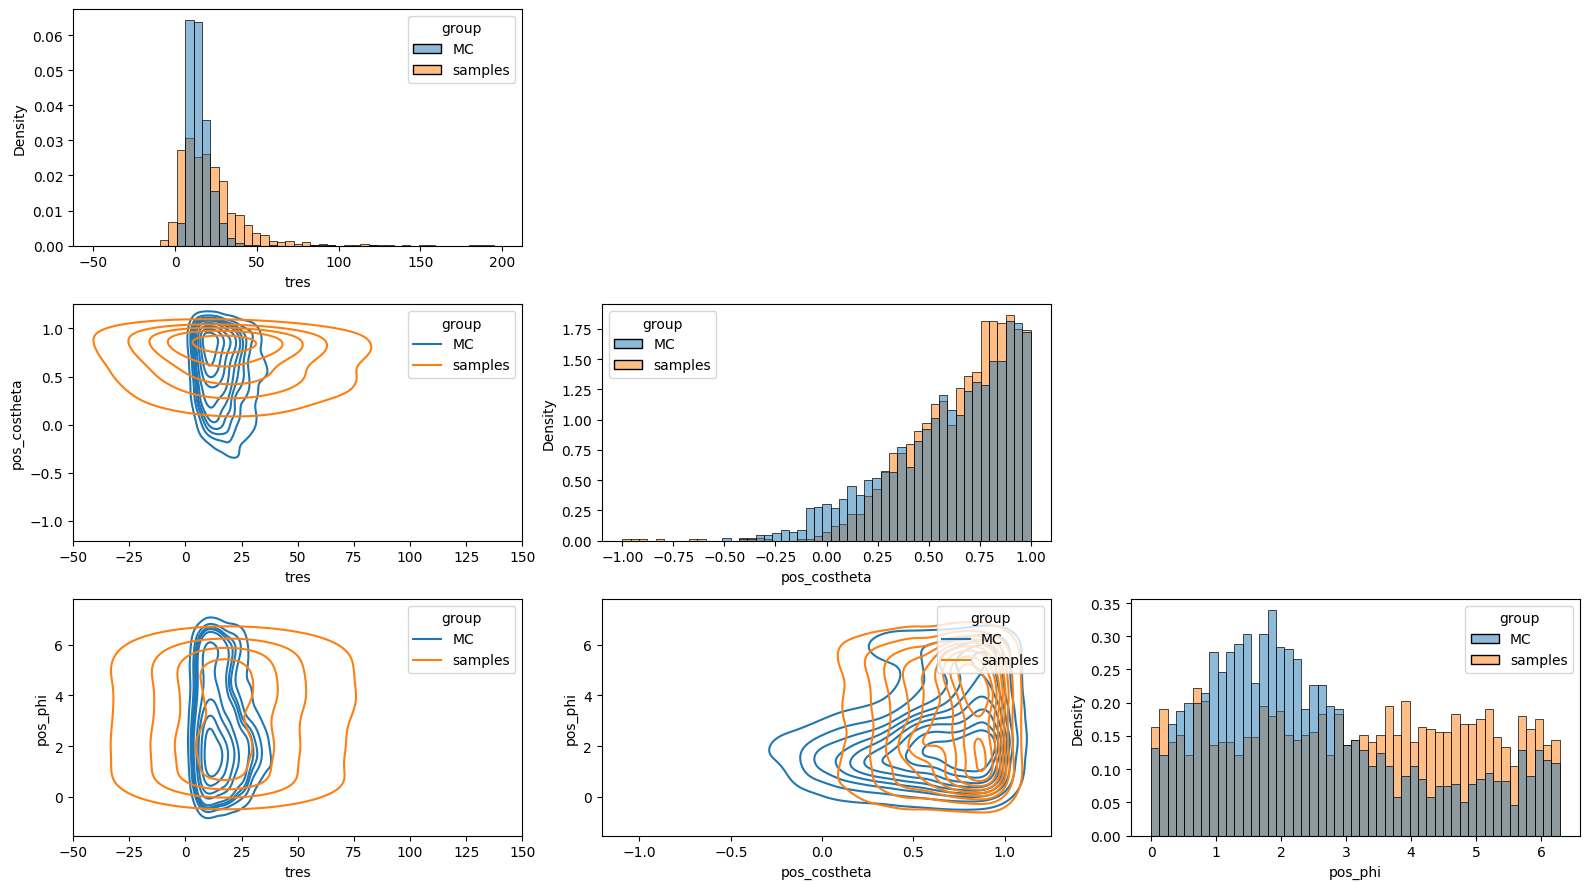

In [53]:
data_df, labels_plot = read_photon_table_hdf_unweighted("../assets/photon_tables_extended_1.hd5", 310, ds)
data_df = data_df.loc[:2000, :]
fig = make_plot(pdf, data_df, labels_plot, traf)

In [66]:
data

,tres,pos_x,pos_y,pos_z,weight,pos_theta,pos_phi,group
0,3.904598,-0.054355,-0.076786,0.186932,0.008720,0.473119,4.096396,MC
1,7.732266,-0.066591,0.192493,0.050645,0.000283,1.327226,1.903850,MC
2,7.337506,-0.156248,0.101720,0.096641,0.001115,1.092579,2.564503,MC
3,2.542782,0.203596,0.034555,0.039415,0.000001,1.381986,0.168121,MC
4,5.134152,-0.012030,0.148058,0.148304,0.003726,0.786666,1.651868,MC
...,...,...,...,...,...,...,...,...
1361,3.615931,NaN,NaN,NaN,NaN,1.672832,6.005152,samples
1362,1159.018822,NaN,NaN,NaN,NaN,0.622218,5.687888,samples
1363,1.486053,NaN,NaN,NaN,NaN,1.541207,5.520656,samples
1364,1158.919930,NaN,NaN,NaN,NaN,0.697183,2.302784,samples


In [ ]:



fig=plt.figure(figsize=(8,6))
helper_fns.visualize_pdf(
    pdf.to("cpu"),
    fig,
    nsamples=10000,
    conditional_input=labels,
    bounds=[[-50, 150], [0, np.pi], [0, 2*np.pi]],
    #s2_norm="lambert"
    );

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_theta"] = sph[:, 0]
data_df["pos_phi"] = sph[:, 1]
corner.corner(data_df.loc[:, ["tres", "pos_theta", "pos_phi"]], range=[[-50, 150], [0, np.pi], [0, 2*np.pi]], weights=data_df["weight"]);

In [23]:

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_costheta"] = np.cos(sph[:, 0])
data_df["pos_phi"] = sph[:, 1]

sns.pairplot(data=data_df,  kind="hist", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50), np.linspace(0, np.pi, 50)))

/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


TypeError: pairplot() got an unexpected keyword argument 'weights'

/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:410: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


<AxesSubplot:xlabel='tres', ylabel='Count'>

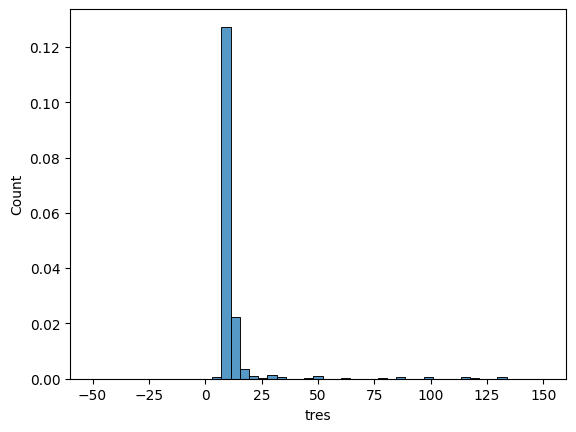

In [14]:

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_theta"] = sph[:, 0]
data_df["pos_phi"] = sph[:, 1]

sns.histplot(data=data_df, x="tres", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50)))
#sns.histplot(data=data_df, x="tres", y="pos_theta", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50), np.linspace(0, np.pi, 50)))

/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


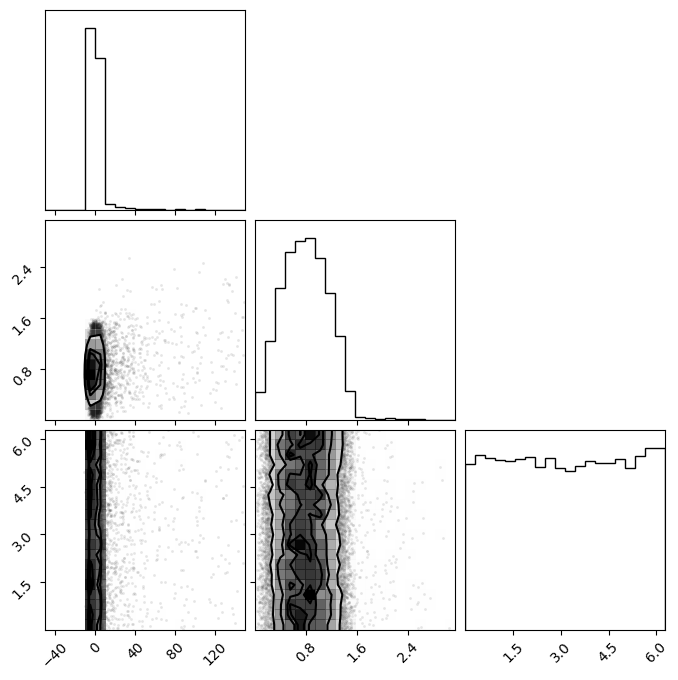

In [33]:
data_df["tres"].max()

2757.6150066785513

{'dir_costheta': 0.8359375, 'dir_phi': 5.129631754689584, 'distance': 17.518126, 'energy': 1445.9599030674115}


<AxesSubplot:>

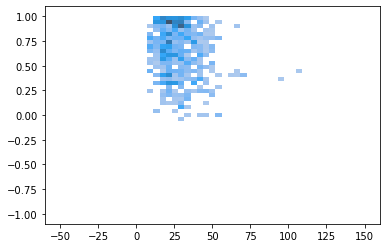

In [39]:
f = h5py.File("../assets/photon_table.hd5")
g = f["photons"]["dataset_5"]
print(dict(g.attrs))

t = g[0, :]
costheta = (g[3, :])/ 0.21
w = g[4, :] 

sns.histplot(x=t, y=costheta, weights=w, bins=(np.linspace(-50, 150, 50), np.linspace(-1, 1, 50)))



In [173]:
ds = HDF5PhotonTableUnWeighted("../assets/photon_table.hd5", 0, -1)

split_len = int(np.ceil(0.7*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=5000)


In [174]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6, hidden_mlp_dims_sub_pdfs="128-128").to(device)
optim = Adam(pdf.parameters(), lr=0.001)
writer = SummaryWriter("/tmp/tensorboard/nflow")

train_iter = 0
for epoch in range(100):
    loss = 0
    for (times, labels) in train_loader:
        train_iter += 1
        optim.zero_grad()

        times = times.to(device)
        labels = labels.to(device)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

        
        writer.add_scalar('Loss/train_batch', neg_log_loss.detach(), train_iter)
       
    loss /= len(train_loader)
    

    loss_test = 0
    for (times, labels) in test_loader:
        times = times.to(device)
        labels = labels.to(device)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf).mean().detach()
    
    loss_test /= len(test_loader)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', loss_test, epoch)
    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



Epoch: 0  Loss Train: 7.61697  Loss Test: 0.69103
Epoch: 1  Loss Train: 0.28901  Loss Test: 0.19059
Epoch: 2  Loss Train: -0.11465  Loss Test: -0.54839
Epoch: 3  Loss Train: -0.10911  Loss Test: 0.09051
Epoch: 4  Loss Train: -0.31770  Loss Test: -0.43644
Epoch: 5  Loss Train: -0.59765  Loss Test: -1.56887
Epoch: 6  Loss Train: -0.81650  Loss Test: -1.23166
Epoch: 7  Loss Train: -0.68624  Loss Test: -0.07817
Epoch: 8  Loss Train: -0.57321  Loss Test: 0.21466
Epoch: 9  Loss Train: -0.56256  Loss Test: 1.07041
Epoch: 10  Loss Train: -0.77607  Loss Test: -1.35035
Epoch: 11  Loss Train: -1.02560  Loss Test: -0.95751
Epoch: 12  Loss Train: -0.93566  Loss Test: -1.07447
Epoch: 13  Loss Train: -1.17724  Loss Test: -1.66004
Epoch: 14  Loss Train: -1.45918  Loss Test: -1.80059
Epoch: 15  Loss Train: -1.24437  Loss Test: -0.71457
Epoch: 16  Loss Train: -1.06902  Loss Test: -1.26076
Epoch: 17  Loss Train: -1.26606  Loss Test: -1.82894
Epoch: 18  Loss Train: -1.17430  Loss Test: -1.28626
Epoch: 19 

KeyboardInterrupt: 

In [175]:
ev = read_table_hdf_unweighted("../assets/photon_table.hd5", 80)
print(ev[1])

100
{'dir_phi': 1.7590525497075664, 'dir_theta': 2.396567576390611, 'distance': 13.915788650512695, 'energy': 100000.0, 'pos_phi': 2.4195030515550093, 'pos_theta': 0.3591260640446554}


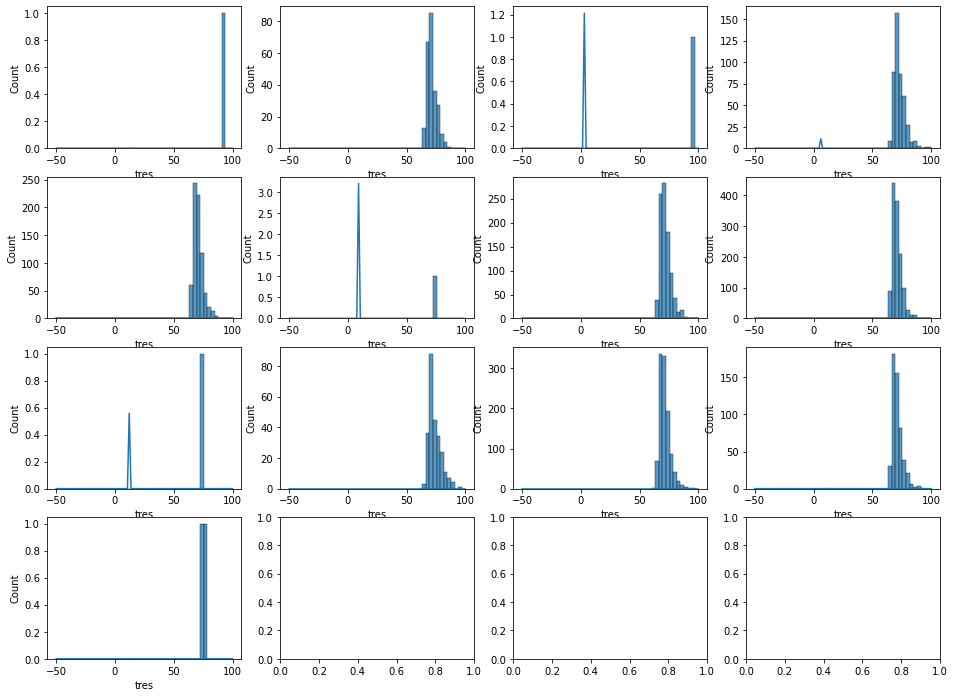

In [176]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]

for i, (grpname, grp) in enumerate(ev[0].groupby("pmt_id")):
    row, col = divmod(i, 4)
    ax = axs[row][col]
    x = grp["tres"]
    #weights = grp["weight"]
    sns.histplot(x=x, bins=np.linspace(-50, 100, 50), ax=ax)

    pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor([int(grpname) - 1]), 16)
    xs = torch.linspace(-50, 100, 100)
    labels = torch.empty((xs.shape[0], 16 + len(label_order)), dtype=torch.float64)
    labels_d = ev[1]
    for i, label in enumerate(label_order):
        labels[:, i] = labels_d[label]
    labels[:, len(label_order):] = pmt_encoding
    labels[:, 0] = np.log10(labels[:, 0])
    labels[:, 1] = np.log10(labels[:, 1])

    logpdf, _, _ = pdf(xs[:, np.newaxis].to(device), conditional_input=labels.to(device))
    ax.plot(xs, torch.exp(logpdf).detach().cpu() )
     



In [12]:
ev

(tensor([88.9582, 88.6213, 88.5577,  ..., 91.2363, 89.3823, 91.6626],
        dtype=torch.float64),
 tensor([1.8697e-05, 6.4915e-06, 1.9423e-08,  ..., 7.2944e-06, 2.3484e-05,
         2.6958e-08], dtype=torch.float64),
 tensor([[1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000]],
        dtype=torch.float64))

/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:419: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


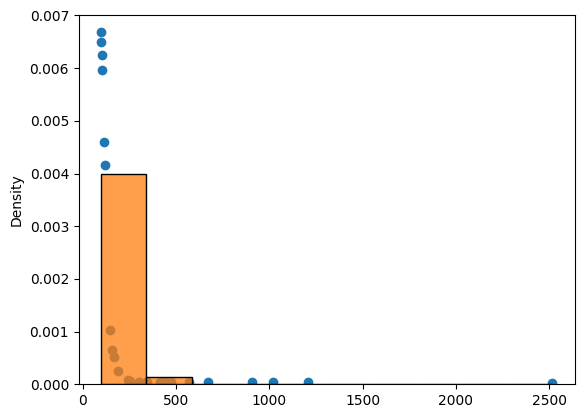

In [10]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6, hidden_mlp_dims_sub_pdfs="128-128").to(device)
optim = Adam(pdf.parameters(), lr=0.001)

for epoch in range(100):
    loss = 0
    for (times, weights, labels) in train_loader:
        optim.zero_grad()

        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)

        weights = weights / torch.sum(weights) * len(weights)

        if any(~torch.isfinite(weights)):
            raise RuntimeError

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf * weights).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

    loss /= len(train_loader)
    

    loss_test = 0
    for (times, weights, labels) in test_loader:
        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)
        weights = weights / torch.sum(weights) * len(weights)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf * weights).mean().detach()
    
    loss_test /= len(test_loader)

    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



In [10]:
test_times, test_labels = next(iter(test_dataset))

logpdf, _, _ = pdf(test_times[:, np.newaxis], conditional_input=test_labels)


In [13]:
test_times

tensor([176.8423, 178.5658], device='cuda:0', dtype=torch.float64)

<AxesSubplot: >

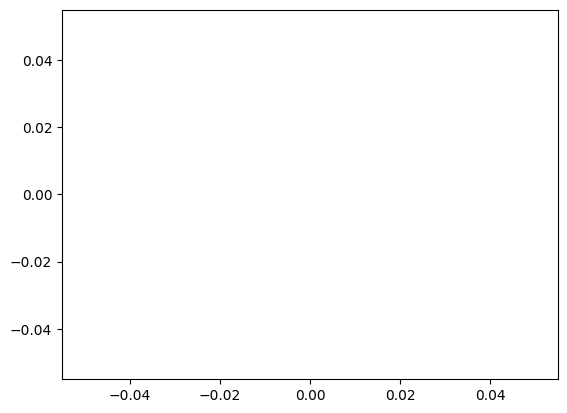

In [12]:
plt.scatter(test_times[mask].detach().cpu(), np.exp(logpdf[mask].detach().cpu()))
sns.histplot(test_times[mask].detach().cpu(), stat="density")

<AxesSubplot:ylabel='Density'>

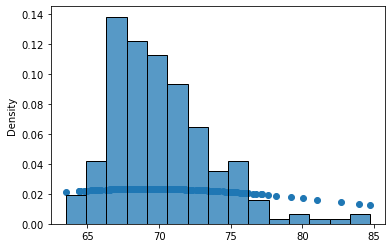

In [29]:
plt.scatter(test_per_pmt[:].detach().cpu(), np.exp(logpdf.detach().cpu()))
sns.histplot(test_per_pmt[:].detach().cpu(), stat="density")

In [34]:
labels, features = next(iter(dl))

ValueError: Shape of passed values is (2, 5126), indices imply (2, 2)

In [9]:
pdf=jammy_flows.pdf("e1", "gggg")

<KeysViewHDF5 ['dataset_1', 'dataset_10', 'dataset_11', 'dataset_12', 'dataset_2', 'dataset_3', 'dataset_4', 'dataset_5', 'dataset_6', 'dataset_7', 'dataset_8', 'dataset_9']>

In [9]:
with h5py.File("../assets/photon_table.hd5") as hdl:
    print(hdl["photon_tables/dataset_2"][:, 0])

IndexError: Index (0) out of range for empty dimension